In [1]:
import yfinance as yf

# Download Tesla stock data
tesla_data = yf.download("TSLA", start="2010-01-01", end="2024-09-24")

# Display the first and last few rows of the data
print(tesla_data.head())
print(tesla_data.tail())




[*********************100%***********************]  1 of 1 completed

                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2010-06-29  1.266667  1.666667  1.169333  1.592667   1.592667  281494500
2010-06-30  1.719333  2.028000  1.553333  1.588667   1.588667  257806500
2010-07-01  1.666667  1.728000  1.351333  1.464000   1.464000  123282000
2010-07-02  1.533333  1.540000  1.247333  1.280000   1.280000   77097000
2010-07-06  1.333333  1.333333  1.055333  1.074000   1.074000  103003500
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-09-17  229.449997  234.570007  226.550003  227.869995  227.869995   
2024-09-18  230.089996  235.679993  226.880005  227.199997  227.199997   
2024-09-19  234.000000  244.240005  232.130005  243.919998  243.919998   
2024-09-20  241.520004  243.990005  235.919998  238.250000  238.250000   
2024-09-23  242.610001  250.000000  241.91999

In [2]:
tesla_data.reset_index(inplace=True)

In [3]:
tesla_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
1,2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2,2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
3,2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
4,2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


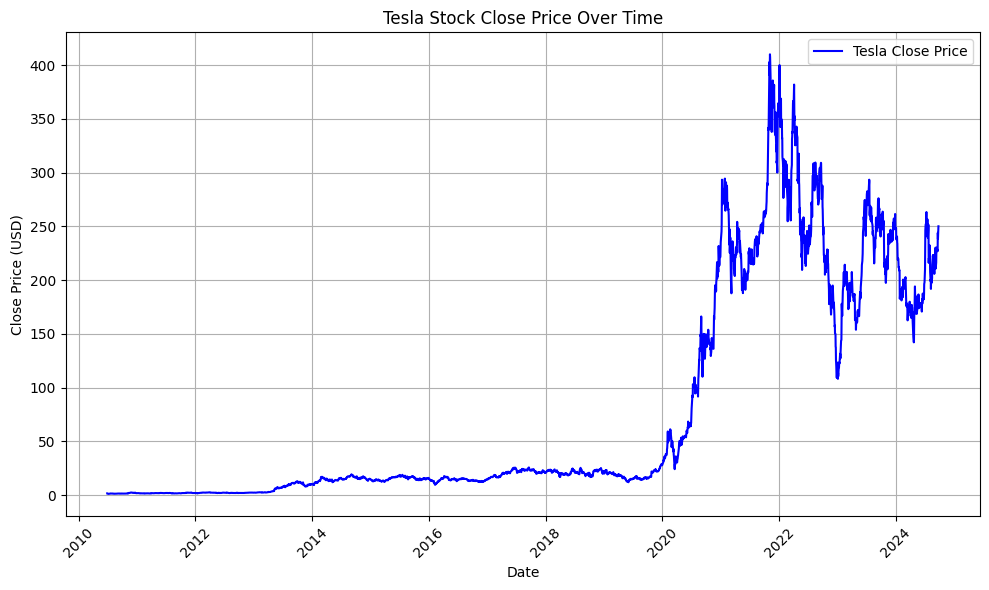

In [4]:
# Plot the Close prices with respect to the Date
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(tesla_data['Date'], tesla_data['Close'], label='Tesla Close Price', color='blue')

# Add title and labels
plt.title('Tesla Stock Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.grid(True)  # Add grid for better readability
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

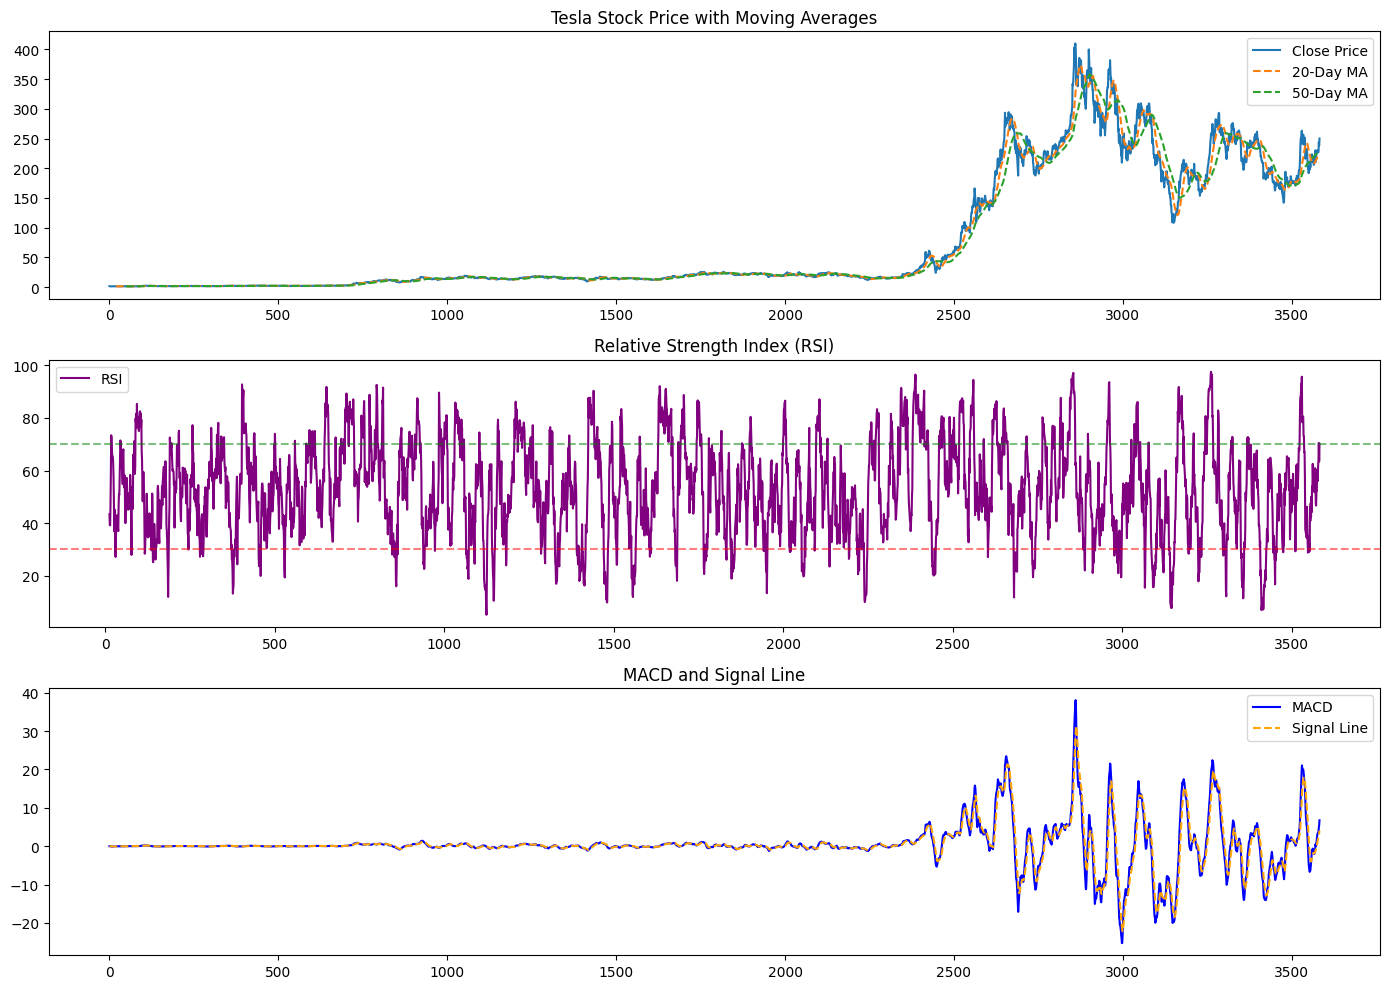

In [5]:
import numpy as np

# Calculate Moving Averages (MA)
tesla_data['MA20'] = tesla_data['Close'].rolling(window=20).mean()
tesla_data['MA50'] = tesla_data['Close'].rolling(window=50).mean()

# Calculate Relative Strength Index (RSI)
delta = tesla_data['Close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

average_gain = gain.rolling(window=14).mean()
average_loss = loss.rolling(window=14).mean()

rs = average_gain / average_loss
tesla_data['RSI'] = 100 - (100 / (1 + rs))

# Calculate Moving Average Convergence Divergence (MACD)
ema12 = tesla_data['Close'].ewm(span=12, adjust=False).mean()
ema26 = tesla_data['Close'].ewm(span=26, adjust=False).mean()
tesla_data['MACD'] = ema12 - ema26
tesla_data['Signal Line'] = tesla_data['MACD'].ewm(span=9, adjust=False).mean()

# Plot the technical indicators along with the closing price
plt.figure(figsize=(14, 10))

# Plot Close price with Moving Averages
plt.subplot(3, 1, 1)
plt.plot(tesla_data['Close'], label='Close Price')
plt.plot(tesla_data['MA20'], label='20-Day MA', linestyle='--')
plt.plot(tesla_data['MA50'], label='50-Day MA', linestyle='--')
plt.title('Tesla Stock Price with Moving Averages')
plt.legend()

# Plot RSI
plt.subplot(3, 1, 2)
plt.plot(tesla_data['RSI'], label='RSI', color='purple')
plt.title('Relative Strength Index (RSI)')
plt.axhline(30, linestyle='--', alpha=0.5, color='red')
plt.axhline(70, linestyle='--', alpha=0.5, color='green')
plt.legend()

# Plot MACD and Signal Line
plt.subplot(3, 1, 3)
plt.plot(tesla_data['MACD'], label='MACD', color='blue')
plt.plot(tesla_data['Signal Line'], label='Signal Line', color='orange', linestyle='--')
plt.title('MACD and Signal Line')
plt.legend()

plt.tight_layout()
plt.show()



In [6]:
# Display the dataset with new columns
tesla_data[['Close', 'MA20', 'MA50', 'RSI', 'MACD', 'Signal Line']].tail()


,Close,MA20,MA50,RSI,MACD,Signal Line
3578,227.869995,219.007001,223.123401,61.885345,3.566127,1.976573
3579,227.199997,219.312001,222.420801,64.165899,3.606125,2.302484
3580,243.919998,220.344501,222.034001,70.478786,4.930156,2.828018
3581,238.250000,221.724001,221.978401,63.449970,5.459010,3.354217
3582,250.000000,223.208000,222.013801,70.106145,6.748466,4.033066


In [7]:
from sklearn.model_selection import train_test_split

# Define features and target variable
features = tesla_data[['MA20', 'MA50', 'RSI', 'MACD', 'Signal Line']]
target = tesla_data['Close']

# Drop rows with NaN values created by rolling window functions
features = features.dropna()
target = target[features.index]

# Split the dataset into train (70%) and test (30%) sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((2473, 5), (1061, 5), (2473,), (1061,))

In [9]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN, Bidirectional, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(features)

# Reshape data for LSTM, RNN models (input should be 3D: [samples, time steps, features])
def create_sequences(data, target, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

In [10]:
time_steps = 60  # You can adjust this to define how many days back you want to consider
X_seq, y_seq = create_sequences(X_scaled, target, time_steps)

# Split the data into training and testing sets
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X_seq, y_seq, test_size=0.3, random_state=42)

# LSTM, RNN, Bidirectional LSTM Model Definition
def build_rnn_model(model_type, input_shape):
    model = Sequential()
    if model_type == 'LSTM':
        model.add(LSTM(50, return_sequences=False, input_shape=input_shape))
    elif model_type == 'RNN':
        model.add(SimpleRNN(50, return_sequences=False, input_shape=input_shape))
    elif model_type == 'Bidirectional LSTM':
        model.add(Bidirectional(LSTM(50, return_sequences=False), input_shape=input_shape))

    model.add(Dense(1))  # Output layer to predict closing price
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    return model

# Train and evaluate the models
def train_and_evaluate_model(model_type):
    model = build_rnn_model(model_type, (X_train_seq.shape[1], X_train_seq.shape[2]))
    history = model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, validation_data=(X_test_seq, y_test_seq), verbose=0)
    loss = model.evaluate(X_test_seq, y_test_seq)
    predictions = model.predict(X_test_seq[-30:])  # Predict for the last 30 days of test data
    return model, loss, predictions

In [11]:
# Train LSTM
lstm_model, lstm_loss, lstm_predictions = train_and_evaluate_model('LSTM')

# Train RNN
rnn_model, rnn_loss, rnn_predictions = train_and_evaluate_model('RNN')

# Train Bidirectional LSTM
bilstm_model, bilstm_loss, bilstm_predictions = train_and_evaluate_model('Bidirectional LSTM')

c:\Users\ajays\OneDrive\Documents\I-Neuron Stock Project\stockenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 11709.2227
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 11786.4121
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


c:\Users\ajays\OneDrive\Documents\I-Neuron Stock Project\stockenv\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 7342.5688
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


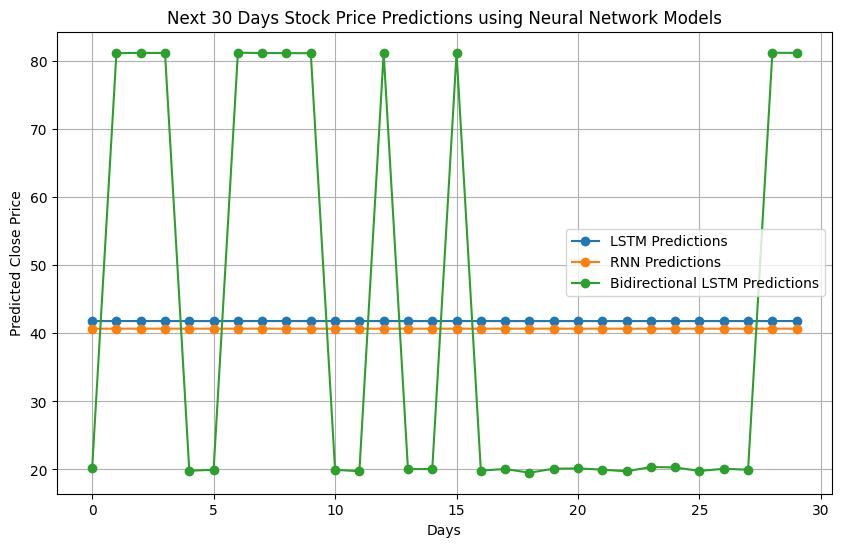

LSTM Loss: 11361.20703125
RNN Loss: 11436.1435546875
Bidirectional LSTM Loss: 7092.7265625


In [12]:
# Plot predictions for the next 30 days from each model
plt.figure(figsize=(10, 6))
plt.plot(lstm_predictions, label='LSTM Predictions', marker='o')
plt.plot(rnn_predictions, label='RNN Predictions', marker='o')
plt.plot(bilstm_predictions, label='Bidirectional LSTM Predictions', marker='o')
plt.title('Next 30 Days Stock Price Predictions using Neural Network Models')
plt.xlabel('Days')
plt.ylabel('Predicted Close Price')
plt.legend()
plt.grid(True)
plt.show()

# Output the losses for comparison
print(f'LSTM Loss: {lstm_loss}')
print(f'RNN Loss: {rnn_loss}')
print(f'Bidirectional LSTM Loss: {bilstm_loss}')

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import RMSprop

# Modify the build_rnn_model to include Dropout layers
def build_rnn_model_with_optimizations(model_type, input_shape, learning_rate=0.001):
    model = Sequential()
    if model_type == 'LSTM':
        model.add(LSTM(50, return_sequences=False, input_shape=input_shape))
    elif model_type == 'RNN':
        model.add(SimpleRNN(50, return_sequences=False, input_shape=input_shape))
    elif model_type == 'Bidirectional LSTM':
        model.add(Bidirectional(LSTM(50, return_sequences=False), input_shape=input_shape))

    # Add Dropout layer to prevent overfitting
    model.add(Dropout(0.2))

    model.add(Dense(1))  # Output layer to predict closing price

    # Use RMSprop optimizer with custom learning rate
    optimizer = RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Callbacks: EarlyStopping and ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Function to train and evaluate the models with optimizations
def train_and_evaluate_model_optimized(model_type):
    model = build_rnn_model_with_optimizations(model_type, (X_train_seq.shape[1], X_train_seq.shape[2]))
    history = model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, validation_data=(X_test_seq, y_test_seq), 
                        verbose=0, callbacks=[early_stopping, reduce_lr])
    loss = model.evaluate(X_test_seq, y_test_seq)
    predictions = model.predict(X_test_seq[-30:])  # Predict for the last 30 days of test data
    return model, loss, predictions

# Train LSTM with optimizations
lstm_model_opt, lstm_loss_opt, lstm_predictions_opt = train_and_evaluate_model_optimized('LSTM')

# Train RNN with optimizations
rnn_model_opt, rnn_loss_opt, rnn_predictions_opt = train_and_evaluate_model_optimized('RNN')

# Train Bidirectional LSTM with optimizations
bilstm_model_opt, bilstm_loss_opt, bilstm_predictions_opt = train_and_evaluate_model_optimized('Bidirectional LSTM')

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1336.1108
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14770.9990
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 13869.3613
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


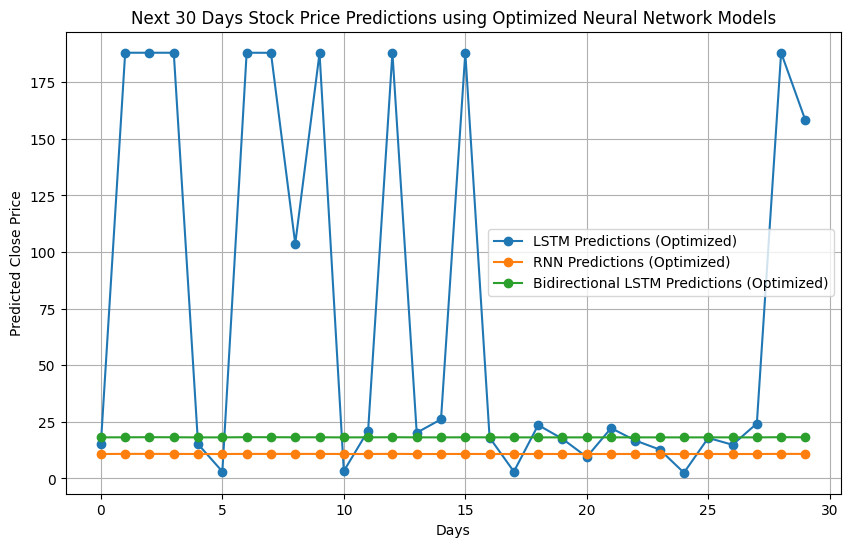

Optimized LSTM Loss: 1279.93505859375
Optimized RNN Loss: 14360.53515625
Optimized Bidirectional LSTM Loss: 13473.5888671875


In [14]:
# Plot predictions for the next 30 days from each model
plt.figure(figsize=(10, 6))
plt.plot(lstm_predictions_opt, label='LSTM Predictions (Optimized)', marker='o')
plt.plot(rnn_predictions_opt, label='RNN Predictions (Optimized)', marker='o')
plt.plot(bilstm_predictions_opt, label='Bidirectional LSTM Predictions (Optimized)', marker='o')
plt.title('Next 30 Days Stock Price Predictions using Optimized Neural Network Models')
plt.xlabel('Days')
plt.ylabel('Predicted Close Price')
plt.legend()
plt.grid(True)
plt.show()

# Output the losses for comparison
print(f'Optimized LSTM Loss: {lstm_loss_opt}')
print(f'Optimized RNN Loss: {rnn_loss_opt}')
print(f'Optimized Bidirectional LSTM Loss: {bilstm_loss_opt}')